# **Laboratorium ADOM 5 i 6 - ZALICZENIE**
---


Obraz `cyfry.png` zawiera 10 różnych obiektów - cyfr od 0 do 9. Wyznacz cechy tych obiektów i spróbuj znaleźć zestaw cech, który umożliwiłby rozóżnienie tych cyfr. Zaproponuj model klasyfikatora oraz przetestuj go na obrazach `cyfry1.png`, `cyfry2.png` i `cyfry3.png`. 


In [2]:
# imports for innitial tests, i don't know which traits ora algorithms will work best for digits differentiation
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from skimage.measure import label,regionprops
import skimage.color as sic
import skimage as si

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree

from tensorflow.keras.preprocessing.image import ImageDataGenerator


C:\Users\moko\anaconda3\envs\openCV\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\moko\anaconda3\envs\openCV\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\moko\anaconda3\envs\openCV\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\moko\anaconda3\envs\openCV\lib\site-packages\tensorflow\python\f

## Load style source image

Source image: (38, 208, 3)
Gray image: (38, 208)
Binary image: (38, 208)


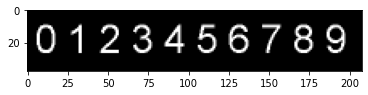

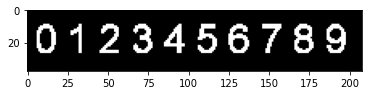

In [7]:
digits_source = cv2.imread('images/cyfry.png')

digits_gray = cv2.cvtColor(digits_source, cv2.COLOR_BGR2GRAY)

# treshold was set to low value, so that bounding boxces would contain whole numbers 
_, digits_binarny = cv2.threshold(digits_gray,1,255,cv2.THRESH_BINARY)

print('Source image: {}'.format(digits_source.shape))
print('Gray image: {}'.format(digits_gray.shape))
print('Binary image: {}'.format(digits_binarny.shape))

plt.imshow(digits_gray, cmap='gray')
plt.show()
plt.imshow(digits_binarny, cmap='gray')
plt.show()

## Label data

Labels of objects :[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


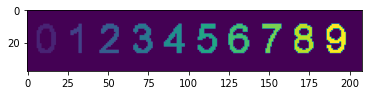

In [8]:
digits_labels = label(digits_binarny)

print('Labels of objects :{}'.format(list(np.unique(digits_labels))[1:]))

plt.imshow(digits_labels)
plt.show()

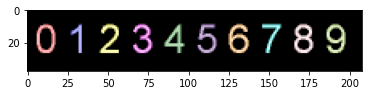

In [9]:
# nałożenie etykiet na obraz oryginalny
labeled_digits_source = sic.label2rgb(digits_labels, image=digits_source, bg_label=0)
plt.imshow(labeled_digits_source)

#### Entry analysis and features extraction

In [10]:
# analiza cech (miejsce na kod)
# basic properties of dataset
digits_features = regionprops(digits_labels)

# looking at the data structure
print('Data struc. type: {}\n'.format(type(digits_features)))
print('Data struc. of elem: {}\n'.format(type(digits_features[1])))

# looking at properties of regionprops class to determine what to use
print(dir(digits_features[0]))

Data struc. type: <class 'list'>

Data struc. of elem: <class 'skimage.measure._regionprops.RegionProperties'>

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cache', '_cache_active', '_intensity_image', '_intensity_image_double', '_label_image', '_ndim', '_slice', 'area', 'bbox', 'bbox_area', 'centroid', 'convex_area', 'convex_image', 'coords', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'filled_area', 'filled_image', 'image', 'inertia_tensor', 'inertia_tensor_eigvals', 'intensity_image', 'label', 'local_centroid', 'major_axis_length', 'max_intensity', 'mean_intensity', 'min_intensity', 'minor_axis_length', 'moments', 'moments_central', 'momen

In [11]:
def create_features(img_features, labels_count):
    # using dataframe to save features of the digits
    features_df = pd.DataFrame()

    # create temp lists - we know there are 10 classes of digits 0-9
    digits = np.arange(0, labels_count)
    bb_ratio = np.zeros(labels_count)
    center_ratio = np.zeros(labels_count)
    area_bb_ratio = np.zeros(labels_count)
    area_conv_ratio = np.zeros(labels_count)
    area_fill_ratio = np.zeros(labels_count)
    ee_num = np.zeros(labels_count)

    for digit, feature in enumerate(img_features):
        # digit ceter
        y0, x0 = feature.centroid
        # bounding box
        minr, minc, maxr, maxc = feature.bbox
        bb_ratio[digit] = (maxr-minr)/(maxc-minc)

        # ratio between maxbb_center and minbb_center, the distances between center and the vertices of the bbox
        center_ratio[digit] = np.sqrt((y0-maxr)**2+(x0-maxc)**2)/np.sqrt((y0-minr)**2+(x0-minc)**2)

        area = feature.area
        bb_area = feature.bbox_area
        convex_area = feature.convex_area
        filled_area = feature.filled_area
        area_bb_ratio[digit] = area/bb_area
        area_conv_ratio[digit] = area/convex_area
        area_fill_ratio[digit] = area/filled_area    

        ee_num[digit] = feature.euler_number

    features_df['digit'] = digits
    features_df['area_bb_ratio'] = area_bb_ratio
    features_df['area_conv_ratio'] = area_conv_ratio
    features_df['area_fill_ratio'] = area_fill_ratio
    features_df['bb_ratio'] = bb_ratio
    features_df['center_ratio'] = center_ratio
    features_df['euler_number'] = ee_num
    
    return features_df

#### Obserwacja wstepna cech
Prosty klasyfikator który zostanie zbudowany moze nie działać dobrze dla cech względnych. Jeśli pojawi się na wejściu obraz o innym rozmiarze lub stosunku wymiarów, prosty klasyfikator moze się pogubić. 
Dlatego zdecydowałem się na wyodrębnienie dodatkowych cech na podstawie tych już obecnych, stosunki rozmiarów czy odległości są znacznie lepsze niż czyste rozmiary, niosą ze sobą więcej informacji i lepiej pozwalają opisać badany obiekt.

In [12]:
features_df = create_features(digits_features, 10)

In [13]:
features_df.head(10)

,digit,area_bb_ratio,area_conv_ratio,area_fill_ratio,bb_ratio,center_ratio,euler_number
0,0,0.509259,0.572917,0.591398,1.500000,1.105451,0.0
1,1,0.404762,0.607143,1.000000,2.571429,1.300157,1.0
2,2,0.462963,0.500000,1.000000,1.500000,1.049349,1.0
3,3,0.509259,0.575916,1.000000,1.500000,1.064977,1.0
4,4,0.431624,0.691781,0.870690,1.384615,0.955846,0.0
5,5,0.518519,0.580311,1.000000,1.500000,1.177998,1.0
6,6,0.542735,0.635000,0.755952,1.384615,1.147431,0.0
7,7,0.361111,0.541667,1.000000,1.500000,1.746361,1.0
8,8,0.592593,0.670157,0.707182,1.500000,1.161289,-1.0
9,9,0.564815,0.645503,0.762500,1.500000,1.095985,0.0


## Model
Naiwny klasyfikator, dla tak małego zbioru uczącego ciężko będzie stworzyć klasyfikator opary na innym algorytmie

In [14]:
# podział danych na etykiety i cechy
y_train = features_df['digit']
X_train = features_df.drop(['digit'], axis=1)

In [15]:
X_train.head()

,area_bb_ratio,area_conv_ratio,area_fill_ratio,bb_ratio,center_ratio,euler_number
0,0.509259,0.572917,0.591398,1.500000,1.105451,0.0
1,0.404762,0.607143,1.000000,2.571429,1.300157,1.0
2,0.462963,0.500000,1.000000,1.500000,1.049349,1.0
3,0.509259,0.575916,1.000000,1.500000,1.064977,1.0
4,0.431624,0.691781,0.870690,1.384615,0.955846,0.0


#### Drzewa decyzyjne

In [16]:
# model klasyfikatora (miejsce na kod)
tree = DecisionTreeClassifier()

In [17]:
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [18]:
# naiwne sprawdzenie uczenia, czy predykcja na zbiorze uczącym będzie równa oryginalnym etykietom
predictions = tree.predict(X_train)

print('oryginalne: {}'.format(list(y_train)))
print('predykcja : {}'.format(list(predictions)))

oryginalne: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
predykcja : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Test

#### Przygotowanie danych testujących
Obrazy testujące są zupełnie innego typu niż obrazy treningowe, dlatego ich przygotowanie będzie inne.

Dodatkowo, ręcznie zostaną stworzone odpowiednie listy zawierające prawidłowe ciągi któe oczekujemy otrzymać z analizy.

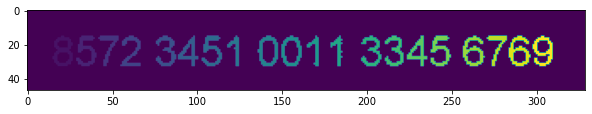

In [46]:
# obróbka wstępna obrazów (miejsce na kod)
# Wszystkie obrazy zostaną przetworzone indywidualnie do formy binych etykiet
digits_test1_real = [8,5,7,2,3,4,5,1,0,0,1,1,3,3,4,5,6,7,6,9]

digits_test1_o = cv2.imread('images/cyfry1.png')
digits_test1 = cv2.cvtColor(digits_test1_o, cv2.COLOR_BGR2GRAY)
digits_test1 = 255-digits_test1
_, digits_test1 = cv2.threshold(digits_test1,100,255,cv2.THRESH_BINARY)
digits_test1_1 = label(digits_test1)
digits_test1 = regionprops(digits_test1_1)

plt.figure(figsize=(10,10))
plt.imshow(digits_test1_1)

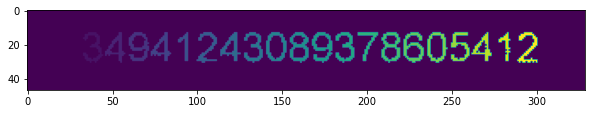

In [49]:
digits_test2_real = [3,4,9,4,1,2,4,3,0,8,9,3,7,8,6,0,5,4,1,2]

digits_test2_o = cv2.imread('images/cyfry2.png')
digits_test2 = cv2.cvtColor(digits_test2_o, cv2.COLOR_BGR2GRAY)
digits_test2 = 255-digits_test2
_, digits_test2 = cv2.threshold(digits_test2,110,255,cv2.THRESH_BINARY)
digits_test2_1 = label(digits_test2)
digits_test2 = regionprops(digits_test2_1)

plt.figure(figsize=(10,10))
plt.imshow(digits_test2_1)

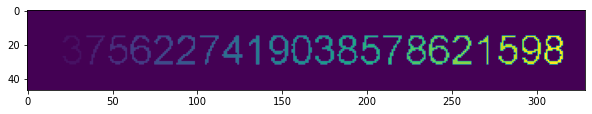

In [48]:
digits_test3_real = [3,7,5,6,2,2,7,4,1,9,0,3,8,5,7,8,6,2,1,5,9,8]

digits_test3_o = cv2.imread('images/cyfry3.png')
digits_test3 = cv2.cvtColor(digits_test3_o, cv2.COLOR_BGR2GRAY)
digits_test3 = 255-digits_test3
_, digits_test3 = cv2.threshold(digits_test3,150,255,cv2.THRESH_BINARY)
digits_test3_1 = label(digits_test3)
digits_test3 = regionprops(digits_test3_1)

plt.figure(figsize=(10,10))
plt.imshow(digits_test3_1)

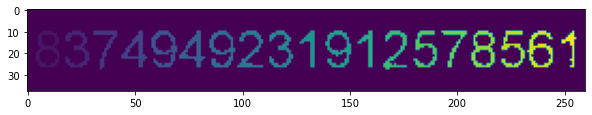

In [47]:
digits_test4_real = [8,3,7,4,9,4,9,2,3,1,9,1,2,5,7,8,5,6,1]

digits_test4_o = cv2.imread('images/cyfry4.png')
digits_test4 = cv2.cvtColor(digits_test4_o, cv2.COLOR_BGR2GRAY)
digits_test4 = 255-digits_test4
_, digits_test4 = cv2.threshold(digits_test4,110,255,cv2.THRESH_BINARY)
digits_test4_1 = label(digits_test4)
digits_test4 = regionprops(digits_test4_1)

plt.figure(figsize=(10,10))
plt.imshow(digits_test4_1)

In [23]:
digits_test1_df = create_features(digits_test1, len(np.unique(digits_test1_1)[1:])).drop(['digit'], axis=1)
digits_test2_df = create_features(digits_test2, len(np.unique(digits_test2_1)[1:])).drop(['digit'], axis=1)
digits_test3_df = create_features(digits_test3, len(np.unique(digits_test3_1)[1:])).drop(['digit'], axis=1)
digits_test4_df = create_features(digits_test4, len(np.unique(digits_test4_1)[1:])).drop(['digit'], axis=1)

In [24]:
digits_test1_df.head(20)

,area_bb_ratio,area_conv_ratio,area_fill_ratio,bb_ratio,center_ratio,euler_number
0,0.504630,0.595628,0.652695,1.500000,1.064594,-1.0
1,0.449074,0.530055,1.000000,1.500000,1.174137,1.0
2,0.314815,0.511278,1.000000,1.500000,1.733881,1.0
3,0.388889,0.432990,1.000000,1.500000,0.998170,1.0
4,0.412037,0.483696,1.000000,1.500000,1.059920,1.0
5,0.365741,0.617188,0.806122,1.500000,0.946922,0.0
6,0.435185,0.516484,1.000000,1.500000,1.203771,1.0
7,0.396825,0.625000,1.000000,2.571429,1.262855,1.0
8,0.430556,0.513812,0.534483,1.500000,1.083285,0.0
9,0.416667,0.497238,0.514286,1.500000,1.117585,0.0


In [25]:
# testy klasyfikatora  (miejsce na kod)
# zdjęcie 1
prediction1 = tree.predict(digits_test1_df)
prediction2 = tree.predict(digits_test2_df)
prediction3 = tree.predict(digits_test3_df)
prediction4 = tree.predict(digits_test4_df)

In [26]:
print('1. Zdjecie 1')
print('oryginal : {}'.format(digits_test1_real))
print('predykcje: {}'.format(list(prediction1)))
print('------------------------------------------------------------------------')

print('2. Zdjecie 2')
print('oryginal : {}'.format(digits_test2_real))
print('predykcje: {}'.format(list(prediction2)))
print('------------------------------------------------------------------------')

print('3. Zdjecie 3')
print('oryginal : {}'.format(digits_test3_real))
print('predykcje: {}'.format(list(prediction3)))
print('------------------------------------------------------------------------')

print('4. Zdjecie 4')
print('oryginal : {}'.format(digits_test4_real))
print('predykcje: {}'.format(list(prediction4)))

1. Zdjecie 1
oryginal : [8, 5, 7, 2, 3, 4, 5, 1, 0, 0, 1, 1, 3, 3, 4, 5, 6, 7, 6, 9]
predykcje: [8, 2, 7, 2, 2, 9, 2, 1, 0, 0, 7, 1, 2, 2, 9, 2, 6, 7, 6, 6]
------------------------------------------------------------------------
2. Zdjecie 2
oryginal : [3, 4, 9, 4, 1, 2, 4, 3, 0, 8, 9, 3, 7, 8, 6, 0, 5, 4, 1, 2]
predykcje: [7, 9, 6, 9, 1, 7, 6, 2, 0, 8, 6, 2, 7, 8, 0, 0, 2, 6, 7, 7]
------------------------------------------------------------------------
3. Zdjecie 3
oryginal : [3, 7, 5, 6, 2, 2, 7, 4, 1, 9, 0, 3, 8, 5, 7, 8, 6, 2, 1, 5, 9, 8]
predykcje: [7, 7, 7, 0, 7, 7, 7, 6, 1, 2, 0, 7, 8, 7, 7, 8, 0, 7, 7, 7, 0, 8]
------------------------------------------------------------------------
4. Zdjecie 4
oryginal : [8, 3, 7, 4, 9, 4, 9, 2, 3, 1, 9, 1, 2, 5, 7, 8, 5, 6, 1]
predykcje: [8, 7, 7, 6, 0, 6, 0, 7, 7, 1, 0, 7, 7, 7, 7, 8, 7, 0, 7]


Wnioski:
*  Jak widac stworzony klasyfikator nie działa zbyt dobrze, najprawdopodobniej przyczyną może być zbyt mała ilość danych wejściowych
*  Podjęta zostanie próba zaimplementowania znacznie lepszego klasyfikatora, który powinien pozwolić na lepszą identyfikację.

---

# CNN + odpowienia obróbka
Podejściem będzie wytworzenie dodatkowej wariancji danych przez preprocessing obrazów, a jako klasyfikatora użyjemy prostej sieci CNN, która powinna znacznie poprawić możliwości rozpoznawania.
W klasycznych gotowych metodach rozpoznawania obiektów jak Tensorflow object API raczej jako wejście używamy zbioru obrazów, do których dodajemy odpowiednie pliki etykietujące. Tutaj wykorzystam inne podejście, ma bazie boundingboxa + 1/2px. (w celu upewnienia się, że cała cyfra jest w polu) wytnę cyfrę, wykonam obróbkę tak wyciętej cyfry do standardowego formatu i tak stworzonego zbioru danych użyję do uczenia i testowania.

Plan przetwarzania:
1. Funkcja przetwarzająca obraz wyjściowy na zestaw obrazów. - w tym odpowiednie powielenie danych które już mamy w zestawie 
2. Stworzenie topologii prostej sieci CNN z warstwą wyjściową zawierającą 10 neuronów (wybór na bazie softmax)
3. Nauczenie sieci 
4. Test sieci

In [27]:
IMG_HEIGHT = 20
IMG_WIDTH = 20

Source image: (38, 208, 3)
Gray image: (38, 208)
Binary image: (38, 208)


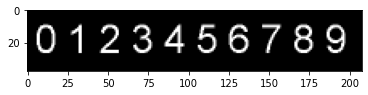

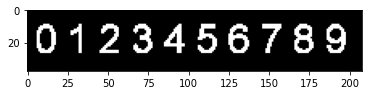

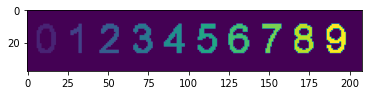

In [28]:
digits_source = cv2.imread('images/cyfry.png')

digits_gray = cv2.cvtColor(digits_source, cv2.COLOR_BGR2GRAY)

# treshold was set to low value, so that bounding boxces would contain whole numbers 
_, digits_binarny = cv2.threshold(digits_gray,1,255,cv2.THRESH_BINARY)

print('Source image: {}'.format(digits_source.shape))
print('Gray image: {}'.format(digits_gray.shape))
print('Binary image: {}'.format(digits_binarny.shape))

plt.imshow(digits_gray, cmap='gray')
plt.show()
plt.imshow(digits_binarny, cmap='gray')
plt.show()

digits_labels = label(digits_binarny)
plt.imshow(digits_labels)
plt.show()

digits_features = regionprops(digits_labels)

#### Funkcja wycinająca liczby
funkcja ma za zadanie wydobyć odpowiednie kawałki zawierające liczby, a następnie przeskalować je i umieścić w DataFrame razem z odpowiednią etykietą

In [346]:
# określenie odpowiedniego zbioru rzeczywistych etykiet
# dodatkowo przeformatujemy liczby na wymiary 20x20, dla łatwiejszej analizy potem

# tu zacznie się funkcja
def crop_elements(source_img, labels, features, train=True):
    plt.imshow(labels)

    images_df = pd.DataFrame(columns=['image'])
    
    labels_count = len(np.unique(labels)[1:])
    
    digits = np.arange(0, labels_count)
    images_cropped = np.zeros((labels_count, 20, 20, 3))
    
    for digit, feature in enumerate(features):
        digits[digit] = digit

        minr, minc, maxr, maxc = feature.bbox
        
        minr = minr - 1
        minc = minc - 1
        maxr = maxr + 1
        maxc = maxc + 1

        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        plt.plot(bx, by, '-y', linewidth=1)

        img_cropped = np.array(source_img[minr:maxr, minc:maxc])
        images_cropped[digit] = np.array(cv2.resize(img_cropped, (20,20), interpolation = cv2.INTER_AREA))

        
        #images_df = images_df.append(pd.DataFrame(columns=['image'], data=[[np.array(img_cropped)]]), ignore_index=True)
    #images_df['image'] = images_cropped                
    #images_df['digit'] = digits

    
    return images_cropped/255, digits

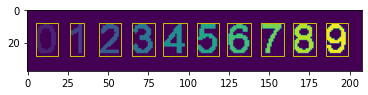

In [347]:
oryginal_img, oryginal_labels = crop_elements(digits_source, digits_labels, digits_features)

In [348]:
# podział a x i y train - dodatkowo należy zamienić dane o cyfrze na 10 kolumn kategorycznych i teakie dane potraktować jako wyjście z sieci
x_train = oryginal_img

y_train = oryginal_labels
y_train = tf.keras.utils.to_categorical(y_train)

In [349]:
y_train

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

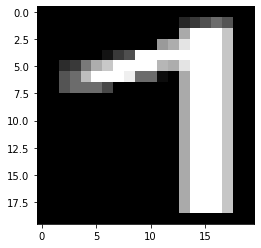

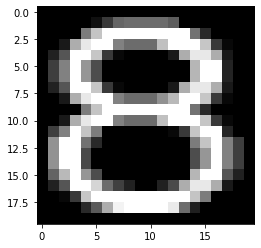

In [350]:
plt.imshow(oryginal_img[1])
plt.show()
plt.imshow(oryginal_img[8])
plt.show()

#### Data Generator 
Ustawienie odpowiedniego generatora danych pozwoli w pewnych zakresach zmieniać zdjęcia przed wprowadzeniem ich do modelu

In [351]:
def invert_colors(img):
    return 1-img

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=5,
    height_shift_range=5,
    zoom_range=[0.95, 1.50],
    preprocessing_function=invert_colors,
    fill_mode='nearest',
    channel_shift_range=0.3)

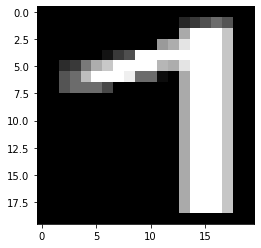

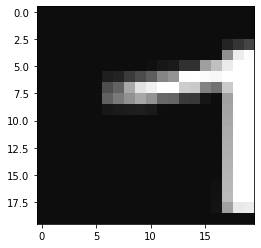

In [352]:
# przykładowa transformacja generatora na '1'
plt.imshow(x_train[1])
plt.show()

plt.imshow(datagen.random_transform(x_train[1]))
plt.show()

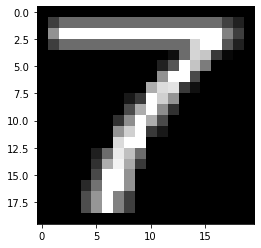

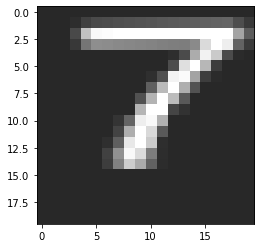

In [353]:
# przykładowa transformacja generatora na '1'
plt.imshow(x_train[7])
plt.show()

plt.imshow(datagen.random_transform(x_train[7]))
plt.show()

Łatwo można zauwazyć, że 1 i 7 moga być pomylone przez model, mam jednak nadzieję, że uda się pominąć taki problem

#### CNN

In [354]:
# import potrzebnych warstw
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

model = Sequential()

# CONVOLUTIONAL LAYER
model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(20, 20, 3), activation='relu',))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2, 2)))
# FLATTEN IMAGES FROM 28 by 28 to 764 BEFORE FINAL LAYER
model.add(Flatten())
# 128 NEURONS IN DENSE HIDDEN LAYER (YOU CAN CHANGE THIS NUMBER OF NEURONS)
model.add(Dense(128, activation='relu'))
# LAST LAYER IS THE CLASSIFIER, THUS 10 POSSIBLE CLASSES
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Early Stopping 

In [355]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=10)

#### Definicja generatorów

In [356]:
train_gen = datagen.flow(x_train, y_train, batch_size=64)

val_gen = datagen.flow(x_train, y_train, batch_size=64)

In [357]:
model.fit_generator(train_gen,
                    epochs=150,
                    validation_data=val_gen)
                    #callbacks=[early_stop])

Epoch 1/150
1/1 [==============================] - 0s 178ms/step - loss: 2.3749 - accuracy: 0.1000 - val_loss: 2.3305 - val_accuracy: 0.1000
Epoch 2/150
1/1 [==============================] - 0s 26ms/step - loss: 2.3166 - accuracy: 0.3000 - val_loss: 2.2957 - val_accuracy: 0.2000
Epoch 3/150
1/1 [==============================] - 0s 110ms/step - loss: 2.2480 - accuracy: 0.3000 - val_loss: 2.2505 - val_accuracy: 0.2000
Epoch 4/150
1/1 [==============================] - 0s 104ms/step - loss: 2.2922 - accuracy: 0.0000e+00 - val_loss: 2.2697 - val_accuracy: 0.1000
Epoch 5/150
1/1 [==============================] - 0s 107ms/step - loss: 2.2764 - accuracy: 0.2000 - val_loss: 2.2742 - val_accuracy: 0.2000
Epoch 6/150
1/1 [==============================] - 0s 116ms/step - loss: 2.2939 - accuracy: 0.0000e+00 - val_loss: 2.2194 - val_accuracy: 0.3000
Epoch 7/150
1/1 [==============================] - 0s 100ms/step - loss: 2.2618 - accuracy: 0.2000 - val_loss: 2.2445 - val_accuracy: 0.6000
Epoch 

In [358]:
# Naiwne sprawdzienie działania klasyfikatora
predict = model.predict(x_train)

print('predykcja: {}'.format(np.argmax(predict, axis=1)))
print('rzeczywis: {}'.format(oryginal_labels))

predykcja: [0 6 8 6 9 6 6 8 6 9]
rzeczywis: [0 1 2 3 4 5 6 7 8 9]


In [359]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

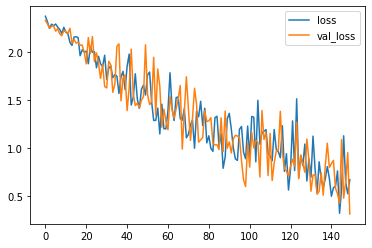

In [360]:
losses[['loss','val_loss']].plot()

#### Przygotowanie danych testowych
Wywolanie ziorow testowych i sprawdzenie ich na zbiorze uczacym

In [361]:
# połączneie zbiorow w jeden testowy, łatwiej bedzie potem wytworzyć odpowiednie metryki
y_test = np.array(digits_test1_real + digits_test2_real + digits_test3_real + digits_test4_real)

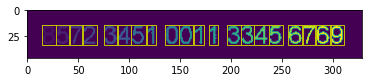

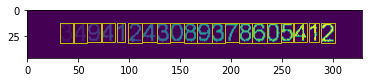

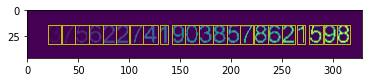

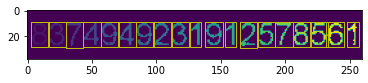

In [362]:
img1, _ = crop_elements(digits_test1_o, digits_test1_1, digits_test1)
plt.show()
img2, _ = crop_elements(digits_test2_o, digits_test2_1, digits_test2)
plt.show()
img3, _ = crop_elements(digits_test3_o, digits_test3_1, digits_test3)
plt.show()
img4, _ = crop_elements(digits_test4_o, digits_test4_1, digits_test4)
plt.show()

In [363]:
x_test = np.append(img1, img2, axis = 0)
x_test = np.append(x_test, img3, axis = 0)
x_test = np.append(x_test, img4, axis = 0)

# sprawdzenie poprawności rozmiaru
print('wymiary x_test: {}'.format(x_test.shape))
print('wymiary y_test: {}'.format(y_test.shape))

wymiary x_test: (81, 20, 20, 3)
wymiary y_test: (81,)


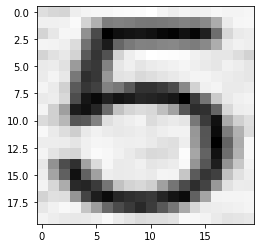

In [364]:
plt.imshow(x_test[1])

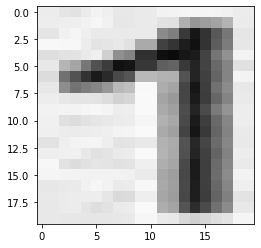

In [365]:
plt.imshow(x_test[7])

#### Testowanie modelu

In [366]:
predictions = model.predict(x_test)

# dane do postaci listy
y_pred = np.argmax(predictions, axis=1)

In [367]:
y_pred

array([8, 5, 7, 2, 3, 4, 5, 1, 0, 0, 1, 1, 3, 3, 4, 5, 6, 7, 6, 9, 3, 4,
       9, 4, 1, 2, 4, 3, 0, 8, 9, 3, 7, 6, 6, 0, 5, 4, 1, 2, 3, 7, 5, 6,
       2, 2, 7, 4, 1, 9, 0, 3, 8, 5, 7, 6, 6, 2, 1, 5, 9, 6, 6, 3, 7, 4,
       9, 4, 9, 2, 3, 1, 9, 1, 2, 5, 7, 6, 5, 6, 1], dtype=int64)

In [368]:
y_pred == y_test

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True])

#### Analiza otrzymanych wyników

In [369]:
from sklearn.metrics import classification_report,confusion_matrix

In [370]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         9
           6       0.55      1.00      0.71         6
           7       1.00      1.00      1.00         8
           8       1.00      0.38      0.55         8
           9       1.00      1.00      1.00         8

    accuracy                           0.94        81
   macro avg       0.95      0.94      0.93        81
weighted avg       0.97      0.94      0.93        81



<AxesSubplot:>

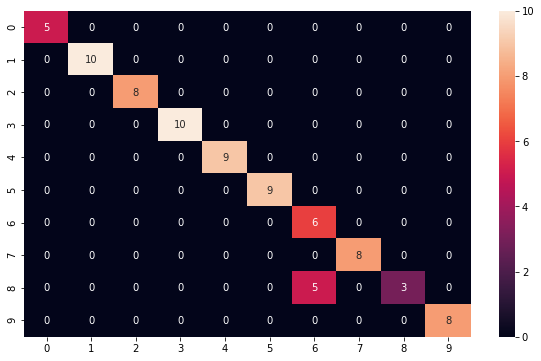

In [371]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

##### Wnioski:
Łatwo można zaobserwować, że niestety ale występują pomyłki. Możnaby spróbować dodać więcj wariancji do generatora lub po prostu więcj danych uczącyh, ale wydaje mi się, ze wyniki tego klasyfikatora są zdecydowanie zadowalające.

#### Użycie modelu do rzeczywistej predykcji

In [372]:
my_number = x_test[8]

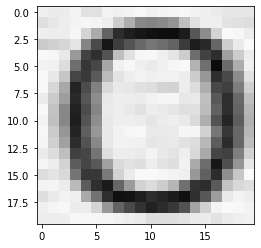

In [373]:
plt.imshow(my_number)

In [374]:
model.predict_classes(my_number.reshape(1,20,20,3))

array([0], dtype=int64)

---
---
Historia zmian:
* wersja r.akad 20/21: 9.11.2020 (MI)